In [1]:
%matplotlib notebook

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

## Recap

                                              FFT
                           Aperture Plane  --------->  Electric Field Beam
                              
                                 |                            |
                                 |                            |
            complex convolution  |                            |  Square
                                 |                            |
                                 |                            |
                                 V                            V
                              
                              UV Plane   <----------  Point Spread Function
                                              iFFT


There are four fundamental planes that you play around with in interferometry. The Aperture Plane is equivalent to the array layout, this is how you choose to place your dishes on the ground. The Electric Field Beam exists because radio telescopes are capable of sampling the electric field, not just measuring the intensity of light (like optical telescopes). The beam that convolves the electric field sky (if you're talking about polarization and need to work with electric fields) is the Electric Field Beam.

The conventional "beam" that you convolve the sky signal (in intensity/power) with is the Point Spread Function or *Synthesized Beam* for interferometers. The UV plane, which is related by a Fourier Transform to the PSF, shows how different modes on the sky are sampled. 

# Aperture Plane

Let us move to a slightly more complicated array layout (shown below). Instead of making them points on a plain page, let me give them a finite definition. The distance between the antennas is measured in units of length (cm, m, km). Here I have assumed a unit of distance to be $10m$, i.e the closest antennas are $10m$ apart.

### Padding with zeros

If you are familiar with Fourier Transforms, you know that the length of the time domain signal determines the frequency resolution. For a similar effect, I will pad the aperature plane with a lot of zeros. This will artifically boost the number of pixels in the PSF and will help us "see" it better.

<IPython.core.display.Javascript object>


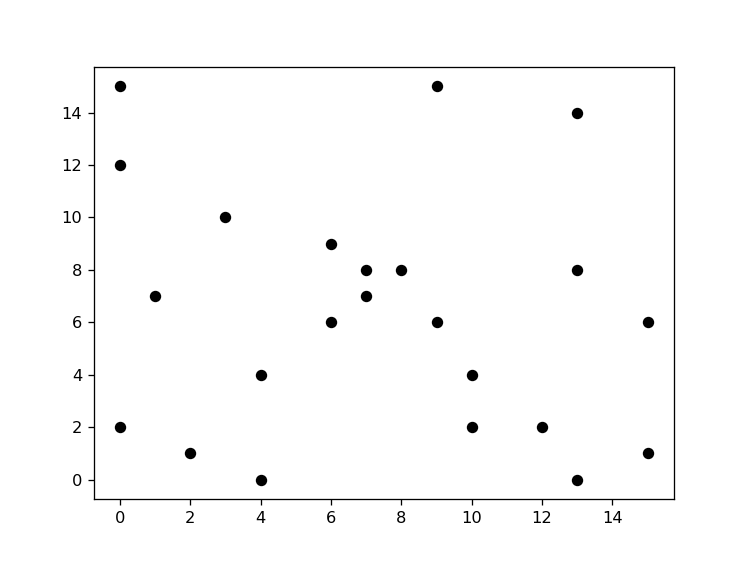

In [2]:
ants = np.array([[0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1],
                 [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0],
                 [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0],
                 [1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1],
                 [0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                 [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
                 [1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0],
                 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                 [0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0]])
ants = np.hstack((ants,np.zeros_like(ants))); ants = np.hstack((ants,np.zeros_like(ants)))
ants = np.hstack((ants,np.zeros_like(ants))); ants = np.hstack((ants,np.zeros_like(ants)))

ants = np.vstack((ants,np.zeros_like(ants))); ants = np.vstack((ants,np.zeros_like(ants)))
ants = np.vstack((ants,np.zeros_like(ants))); ants = np.vstack((ants,np.zeros_like(ants)))

ant_x,ant_y = np.shape(ants)

fig,ax = plt.subplots(1,1)
for m in range(ant_x):
    for l in range(ant_y):
        if ants[m][l]:
            ax.plot(m,l,'k',marker='o')

# UV plane

The UV-plane is a convolution of the antenna array with itself.

$$\text{UV} = A \star A^*$$

### Units

The units of the UV plane are also length, but rather than measure it in fixed units like m, km or cm, astronomers usually measure it in units of $\lambda$. This leads to a *pseudo-scaling* of the UV plane with the frequency of observation, but the choice of these units will become obvious later on.

<IPython.core.display.Javascript object>


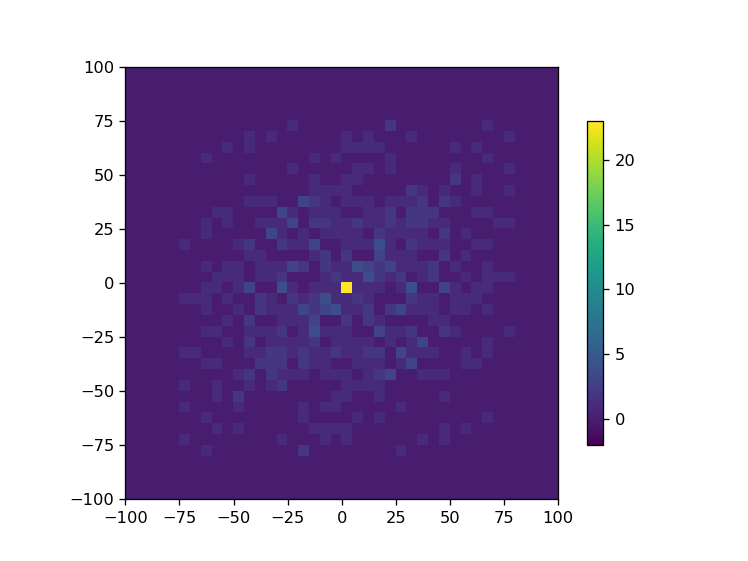

In [3]:
uv_plane = np.fft.fftshift(np.fft.ifft2(np.abs(np.fft.fft2(ants))**2)).T

b  = 10       # in m == 5 * lambda
wv = 2        # 200 cm

uext,vext = np.shape(ants) 
rng = 20

plt.figure()
plt.imshow(np.abs(uv_plane)[uext/2-rng:uext/2+rng,vext/2-rng:vext/2+rng],
           extent=[-(b/wv)*rng,b/wv*rng,-b/wv*rng,b/wv*rng],vmin=-2)
plt.colorbar(shrink=0.75)

Unlike the previous tutorial, this time we have much more UV coverage. This is due to:
1. More antennas
2. Unequal distances between antennas

# Point Spread Function

The PSF of an antenna array is the Fourier transform of the UV plane. This demonstrates what the UV plane translates to on the sky, or gives you the sampling function on the sky. Another way to understand this is- if there was a single point source on the zenith, the PSF is what the telescope sees. Below is the PSF of our array, evidently a point source does not appear like a point source.

A good rule of thumb is, the better the UV coverage the narrower your PSF. A narrow PSF means better resolution and/or fewer grating lobes.

The PSF is in units of angle- arcsecond, more relatistically arcminutes, and for very small dishes arcdegrees.

<IPython.core.display.Javascript object>


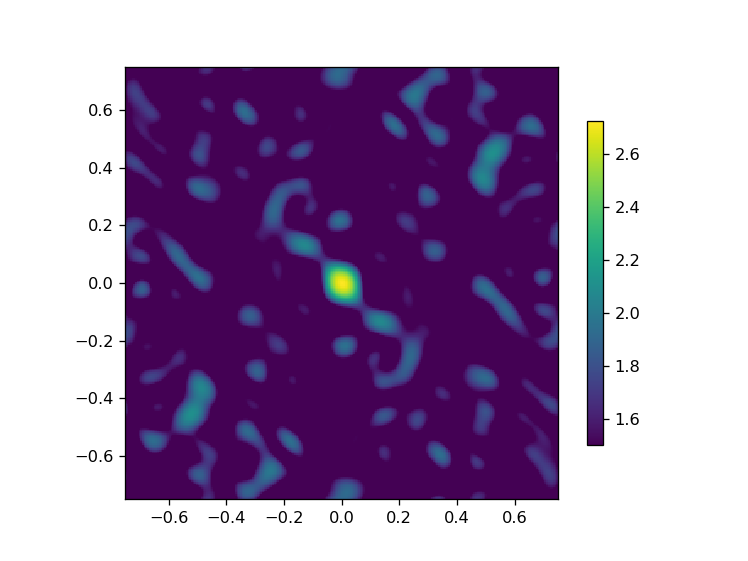

In [4]:
psf = np.fft.fft2(uv_plane)

plt.figure()
plt.imshow(np.log10(np.abs(np.fft.fftshift(psf))),
           extent=[-wv/(16.*b)*60,wv/(16.*b)*60,-wv/(16.*b)*60,wv/(16.*b)*60],
           vmin=1.5)
plt.colorbar(shrink=0.75)

# UV Plane again

We talked about the UV plane in two different ways so far:

1. It is the aperture plane convolved with itself. This is the static sampling function that you get when you choose the layout of your array.

2. The UV plane is populated with visibilities, which is the product of two antenna voltage signals. This is the sampled sky signal that you get from observing a given sky with your chosen array layout.

The third way to understand the UV plane/visibilities is looking at what is theoretically expected. This will tie in neatly into our previous exercise of understanding double slit experiments and interferometer beams so let us try to understand that for a bit.

Consider a sky with a single point source at an angle $\left(\theta_x,\theta_y \right)$ from the zenith, emitting light at a single frequency. A two element interferometer will act like a double slit to this source. By measuring the interference pattern created by this single point source through our double slit (interferometer), we can reconstruct the location of the source. If the electric field at individual antennas is $E_1$ and $E_2$ the interference pattern is given by:


$$I \propto \left| \bar{E_1} + \bar{E_2} \right|^2$$

$$I \propto (\bar{E_1} + \bar{E_2})(\bar{E_1} + \bar{E_2})^*$$

$$I \propto |\bar{E_1}|^2 + |\bar{E_2}|^2 + \bar{E_1}\bar{E_2^*} + \bar{E_1^*}\bar{E_2}$$


$$I \propto \bar{E_1}\bar{E_2^*}$$

The entire interference pattern is uniquely encoded by the product of antenna voltages (remember voltage is proportional to the electric field). These products are what we called *visibilities*.

Theoretically, this product will depend on the location of the source and the wavelength at which we are observing much like the double slit experiment.

$$V_{01} \propto \exp\left(2\pi i \left\{\frac{b_x\theta_x}{\lambda} + \frac{b_y\theta_y}{\lambda}\right\}\right)$$

Generalizing this for multiple sources, weighted by the beam pattern of our telescope, the right formula for theoretically expected visibilitites is called the **Measurement Equation** and is given by:

$$V_{\nu}(u,v) = \int\int A_{\nu}(l,m) I_{\nu}(l,m) e^{-2\pi i \left(ul+vm\right)} dl dm$$

where $u = \frac{b_x}{\lambda}$, $v = \frac{b_y}{\lambda}$ and $l = \theta_x$, $m = \theta_y$ in the small angle approximation.

# Imaging

We finally have all the pieces (almost) required to image a hypothetical sky! Here is the algorithm we will use for imaging:

1. Create a fake source at a fixed frequency and location.
1. Compute the visibilities this fake source will produce.
2. Grid the visibilities on the UV plane (we'll see this in a bit).
3. Fourier transform the gridded UV plane to get an image.


## Simulated sky

Let us simulate a **single point source** in the sky to see how well we can recover it with our fake interferometer. The point source is **at $\left(\frac{\pi}{4},\frac{\pi}{4}\right)$** from the zenith.

In [5]:
# Baseline separation in cm
bx = 1000; by = 1000 

# Simulated sky with a point source
thetax = np.pi/4
thetay = np.pi/4

# Wavelength in cm
wv = 3e10/150e6

# Generate antpos
ant_x, ant_y = np.shape(ants)
antpos = {}; ant_num = 0
for i in range(ant_x):
    for j in range(ant_y):
        if ants[i][j]:
            antpos[ant_num] = np.array([i,j,0])
            ant_num += 1

# Gridding the UV Plane

The most computationally intensive process of imaging with radio interferometers is gridding the UV plane. Once you have all the visibilities generated from the array, you need to find the "right" matrix dimensions to Fourier transform. This process of mapping the visibilities onto the UV plane is called gridding. A (u,v) coordinate is defined as:

$$ u = \frac{b_x}{\lambda} \qquad v = \frac{b_y}{\lambda} $$

Below you can see the effect of over-gridding (more sample points than visibilities) and under-gridding (fewer points than visibilities, causing some visibilities to add up). 

**Overgridding** 
1. Higher resolution 
2. More degeneracy (more sidelobes) 

**Undergridding** 
1. Lower resolution
2. Fewer sidelobes.

This effect is exactly the same as padding with a repeating array.

I am going to compute the theoretical visibilities and grid them at the same time.

In [6]:
def gen_vis(antpos, source, diameter=2, baseline=(10,10), freqs=[150e6], res=256):
    
    """Populate the UV plane for a point source at given coordinates
    
    Parameters
    ----------
    antpos  : dict,  keys as antenna numbers and values as array of x,y,z grid points
    source  : tuple, the angle of the source on the sky (theta_x, theta_y)
    diameter: float, the diameter of each dish in the interferometer
    baseline: tuple, units of baseline separation between antennas (bx, by)
    freq    : float, frequency at which the observation is being made
    res     : int,   resolution- number of points per side of the UV plane
    
    Results
    -------
    UV      : matrix, populated UV plane matrix
    """
    # Source
    thetax,thetay = source
    
    # Baseline
    bx, by = baseline
    
    # Create the grid
    grid_pts = np.array(antpos.values())
    Nx = np.max(grid_pts[:,0])*bx*np.max(freqs)/3e8 # u_max
    Ny = np.max(grid_pts[:,1])*by*np.max(freqs)/3e8 # v_max
    
    u_bins = np.linspace(-Nx,Nx,num=res-1)
    v_bins = np.linspace(-Ny,Ny,num=res-1)
    
    uv = np.zeros([res,res],dtype=np.complex128)
    
    for f in freqs:
        for ant1,pos1 in antpos.items():
            for ant2,pos2 in antpos.items():
                u = (pos2[0]-pos1[0])*bx*f/3e8  # ant pair u index  
                v = (pos2[1]-pos1[1])*by*f/3e8  # ant pair v index
                
                u_pos = np.abs(u_bins - u).argmin() #closest bin idx on grid
                v_pos = np.abs(v_bins - v).argmin() #closest bin idx on grid
                
                # Beam modulation
                Ax = (np.sinc(diameter*np.sin(thetax)*f/3e8))**2
                Ay = (np.sinc(diameter*np.sin(thetay)*f/3e8))**2
                
                # Compute visibility
                vis = Ax*Ay*np.exp(2*np.pi*1j*(u*np.sin(thetax) +v*np.sin(thetay)))
                
                uv[u_pos,v_pos] += vis
            
    return uv.T

<IPython.core.display.Javascript object>


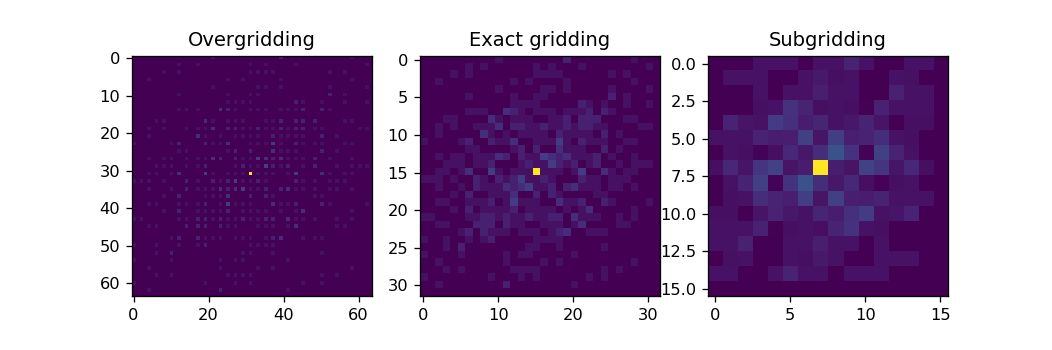

In [23]:
source = (np.pi/4,np.pi/3)
d = 10
b = (100,100)
#source = (0,0)

plt.figure(figsize=(9,3))
plt.subplot(131)
plt.title('Overgridding')
uv = gen_vis(antpos, source, diameter=d, baseline=b, res=64)
plt.imshow(np.abs(uv),cmap='viridis',interpolation='nearest')

plt.subplot(132)
plt.title('Exact gridding')
uv = gen_vis(antpos, source,  diameter=d, baseline=b, res=32)
plt.imshow(np.abs(uv),cmap='viridis',interpolation='nearest')

plt.subplot(133)
plt.title('Subgridding')
uv_sub = gen_vis(antpos, source,  diameter=d, baseline=b, res=16)
plt.imshow(np.abs(uv_sub),cmap='viridis',interpolation='nearest')

<IPython.core.display.Javascript object>


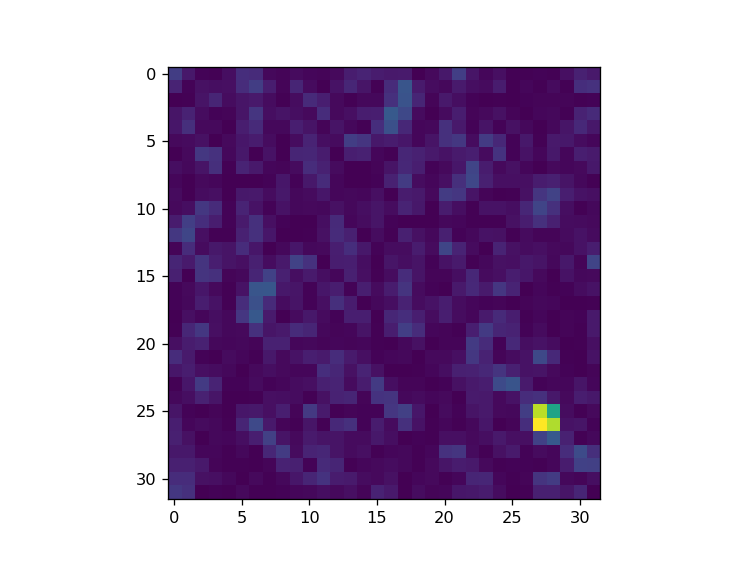

In [36]:
uv = gen_vis(antpos, source, baseline=b, diameter=d, res=32)

img = np.fft.fft2(uv)

plt.figure()
plt.imshow(np.abs(np.fft.fftshift(img)))

# Frequency Synthesis

Remember we said the UV plane *pseudo-scales* with frequency because we are using units of wavelength?

When considering multiple frequencies, the different channels fall into different UV bins since $(u,v)$ coordinates are functions of frequency.

In [66]:
fqs = np.linspace(100,200,num=64)*1e6
uv = gen_vis(antpos, source, diameter=d, baseline=b, freqs=fqs, res=32)

<IPython.core.display.Javascript object>


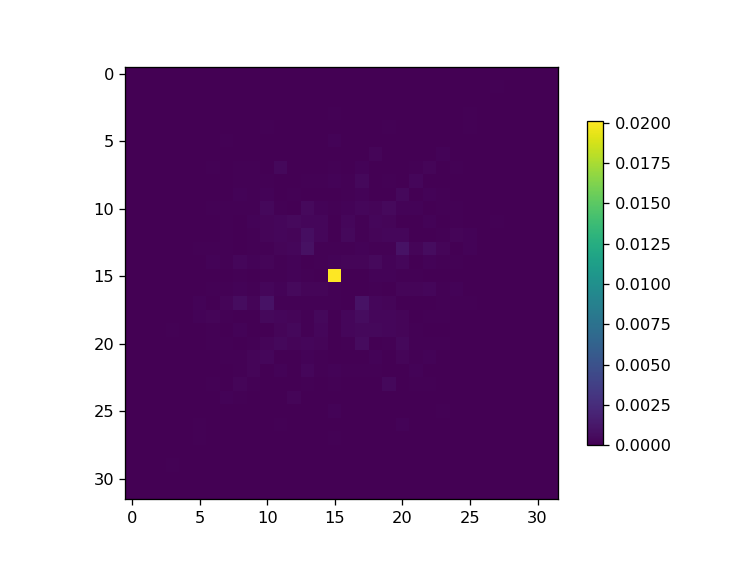

In [67]:
plt.figure()
plt.imshow(np.abs(uv))
plt.colorbar(shrink=0.75)

<IPython.core.display.Javascript object>


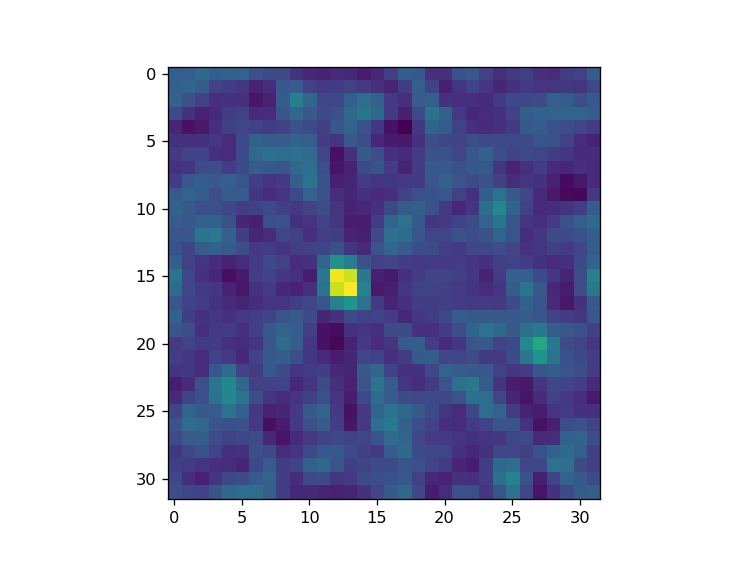

In [68]:
img = np.fft.fft2(uv)

plt.figure()
plt.imshow(np.abs(np.fft.fftshift(img)))